# Portland Data Science Group Meetup
## Applied Data Science — Portland-Area Traffic Accidents (7/8/2018-7/29/2018)

### Basic info
-  Data source (http://dive-into.info/).
-  Traffic accidents in Clackamas, Washington, Multnomah, and Marion from 2012 to 2015.
-  Use data to predict 2016 situation at each county.
-  Three analyses conducted: number of crashes (by month and by year), proportions of road types, and proportions of collision types.

In [1]:
import pandas as pd

counties = ['Clackamas', 'Marion', 'Multnomah', 'Washington']
datdir = 'Data/'
ctydfs = []

for county in counties:
    filename = datdir + county + ".csv"
    ctydfs.append(pd.read_csv(filename, low_memory=False))

# combine all of the counties into a single DataFrame
df = pd.concat(ctydfs)

print(str(df.shape[0]), " total rows over " + str(len(counties)) + " counties")

613904  total rows over 4 counties


### Record type
Record type 1 records the occurence of the accident, including time and geographic location (i.e., latitude and longitude). Type 2 and 3, we believe, deal with participants involved in the accident. Analyses conducted in this notebook only include Record Type 1 data.

In [2]:
# split the data by record type and cut the empty columns
crashes = df.loc[df['Record Type'] == 1]
print(crashes.shape)
crashes = crashes.dropna(axis='columns', how='all')

# record type 2 and 3, restore them separately
df_type2 = df.loc[df['Record Type'] == 2]
df_type2 = df_type2.dropna(axis='columns', how='all')

df_type3 = df.loc[df['Record Type'] == 3]
df_type3 = df_type3.dropna(axis='columns', how='all')

# crashes.head(n=5)
print(crashes.shape)

(118337, 152)
(118337, 97)


In [3]:
crashes['Crash Month'] = crashes['Crash Month'].astype(int)
crashes['Crash Day'] = crashes['Crash Day'].astype(int)
crashes['Crash Year'] = crashes['Crash Year'].astype(int)

# # if month name is the preferred format
# import calendar
# crashes['Crash Month'] = crashes['Crash Month'].apply(lambda x: calendar.month_abbr[x])

# use date (i.e., a "Date" field) to record data (from Bruce)
import datetime

def to_datetime (row):
    month=row['Crash Month']
    day=row['Crash Day']
    year=row['Crash Year']
    dstr = str(month)+"/"+str(day)+"/"+str(year)
    dt = datetime.datetime.strptime(dstr, "%m/%d/%Y").date()
    
    return(dt)

crashes['Date'] = crashes.apply(to_datetime, axis=1)

# Also create a YearMonth column, use number to represent
crashes['YearMonth'] = crashes['Date'].map(lambda x: 100*x.year + x.month)
# crashes['YearMonth'] = crashes['Date'].map(lambda x: str(x.year) + '-' + str(x.month))
# crashes['YearMonth'] = crashes['Date'].apply(lambda x: datetime.datetime.strptime(str(x), '%y-%m-%d'))
# print(crashes['YearMonth'])

In [4]:
# interpret county name
county_dict = {3:'Clackamas', 24:'Marion', 26:'Multnomah', 34:'Washington'}
crashes['County'] = crashes['County Code'].apply(lambda x: county_dict[x])
crashes['County'].value_counts()

Multnomah     54208
Washington    28296
Clackamas     18615
Marion        17218
Name: County, dtype: int64

### Trend by year and county

In [5]:
# crashes by year and county
crashes_freq = crashes.groupby(['County', 'Crash Year']).size().to_frame()
crashes_freq.rename(index=str, columns={0: 'Crash Number'}, inplace=True)
crashes_freq = crashes_freq.reset_index(level='County')
# crashes_freq.set_index('Crash Year', inplace=True)
print(crashes_freq)

Clackamas_freq = crashes_freq.loc[crashes_freq['County'] == 'Clackamas']
Marion_freq = crashes_freq.loc[crashes_freq['County'] == 'Marion']
Multnomah_freq = crashes_freq.loc[crashes_freq['County'] == 'Multnomah']
Washington_freq = crashes_freq.loc[crashes_freq['County'] == 'Washington']

                County  Crash Number
Crash Year                          
2012         Clackamas          4461
2013         Clackamas          4410
2014         Clackamas          4686
2015         Clackamas          5058
2012            Marion          4010
2013            Marion          4167
2014            Marion          4283
2015            Marion          4758
2012         Multnomah         13700
2013         Multnomah         13158
2014         Multnomah         13260
2015         Multnomah         14090
2012        Washington          6700
2013        Washington          6934
2014        Washington          7154
2015        Washington          7508


<IPython.core.display.Javascript object>


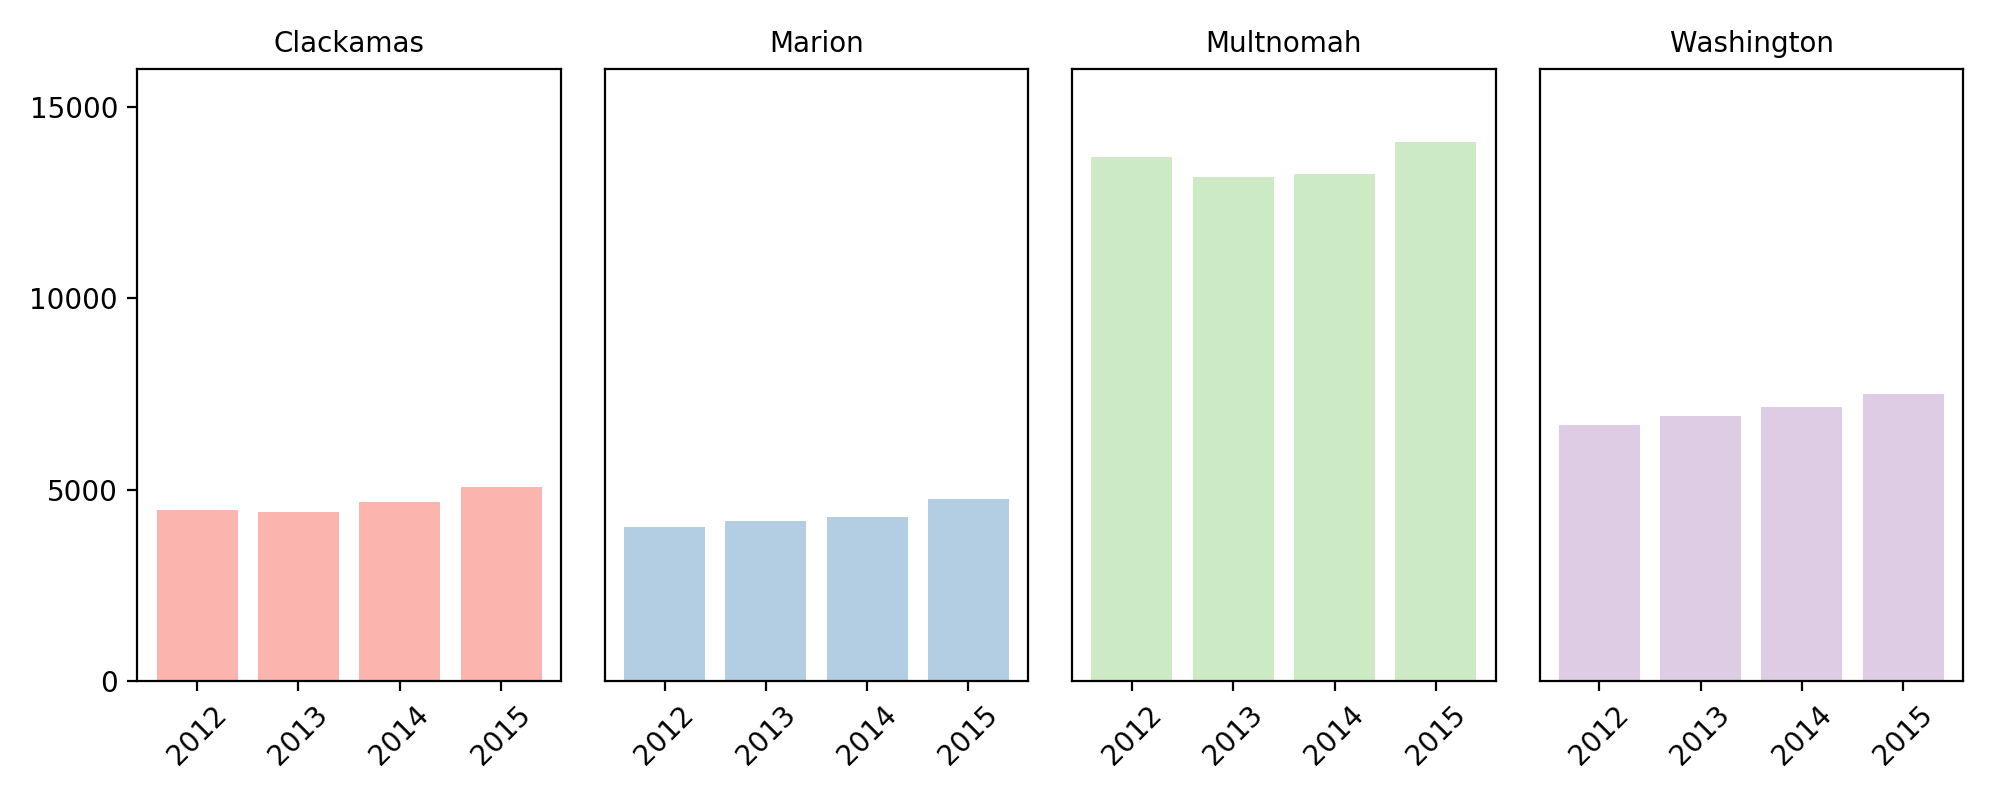

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

county_freq = [Clackamas_freq, Marion_freq, Multnomah_freq, Washington_freq]
# subtitles = ['Clackamas', 'Marion', 'Multnomah', 'Washington']
colors = ['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4']
yticks = np.arange(0, 16000, 5000)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 4))
axes = [ax1, ax2, ax3, ax4]

for num in range(len(axes)):
    axes[num].bar(county_freq[num].index, county_freq[num]['Crash Number'], color=colors[num], align='center')
    axes[num].set_title(counties[num], fontsize=10)
    axes[num].set_ylim(0, 16000)
    if num==0:
        axes[num].set_yticks(yticks)
        axes[num].set_yticklabels(yticks)
    else:
        axes[num].set_yticks([])
    for item in axes[num].xaxis.get_ticklabels():
        item.set_rotation(45) 
plt.tight_layout()

### Seasonal trend by county

In [7]:
# Explore data by month
crashes_cty_mon = crashes.groupby(['County', 'Crash Month']).size().to_frame()
crashes_cty_mon.rename(index=str, columns={0: 'Crash Number'}, inplace=True)
crashes_cty_mon = crashes_cty_mon.reset_index(level='County')
crashes_cty_mon['Crash Number'] = crashes_cty_mon['Crash Number'].div(4)
# crashes_cty_yrmon

Clackamas_mon = crashes_cty_mon[crashes_cty_mon['County']=='Clackamas']
Marion_mon = crashes_cty_mon[crashes_cty_mon['County']=='Marion']  
Multnomah_mon = crashes_cty_mon[crashes_cty_mon['County']=='Multnomah']
Washington_mon = crashes_cty_mon[crashes_cty_mon['County']=='Washington']

<IPython.core.display.Javascript object>


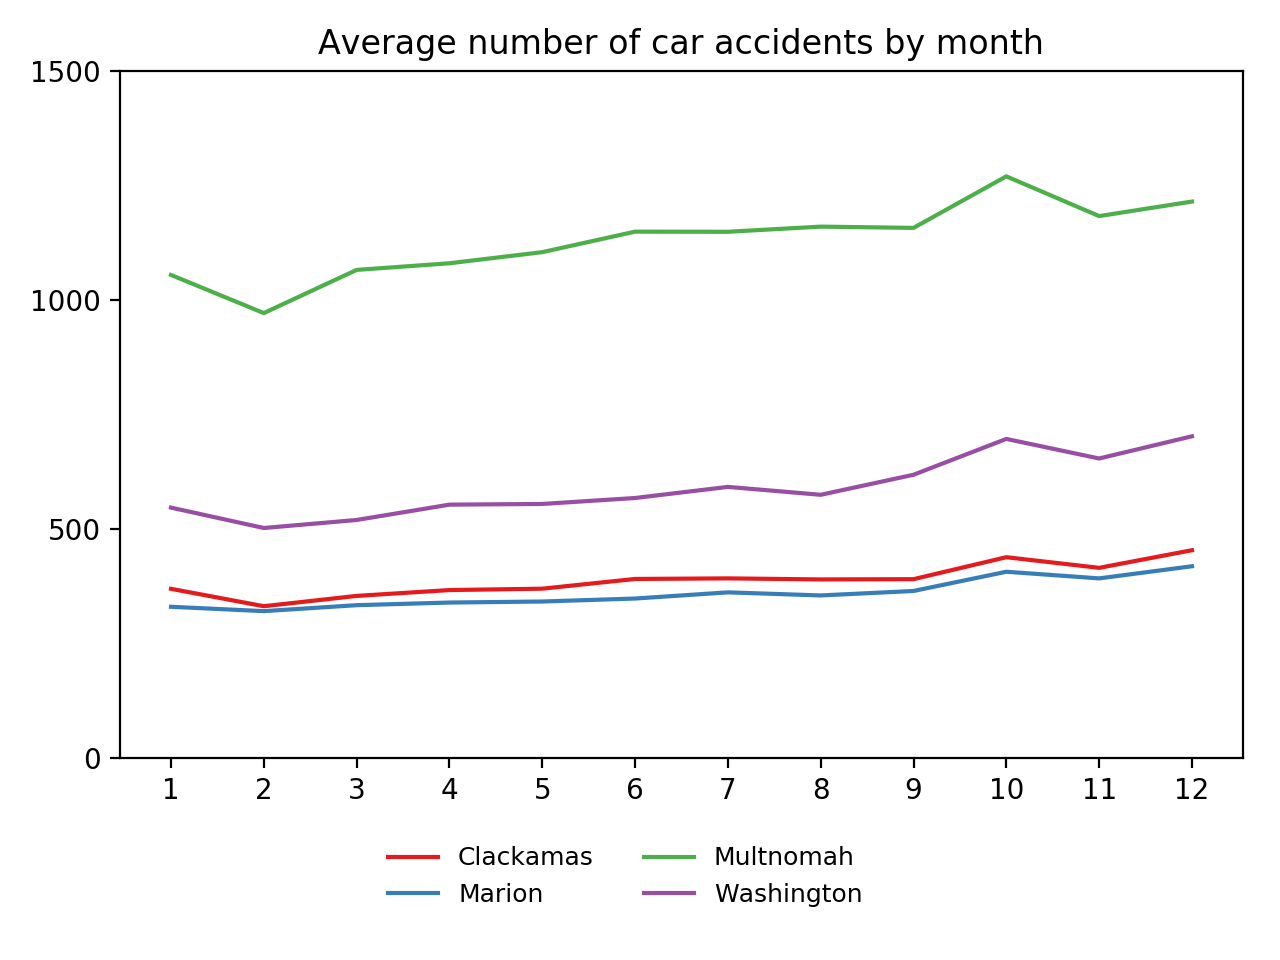

In [8]:
linecolors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
fig, ax = plt.subplots()
ax.plot(Clackamas_mon.index, Clackamas_mon['Crash Number'], color=linecolors[0], label = 'Clackamas') 
ax.plot(Marion_mon.index, Marion_mon['Crash Number'], color=linecolors[1], label = 'Marion') 
ax.plot(Multnomah_mon.index, Multnomah_mon['Crash Number'], color=linecolors[2], label = 'Multnomah') 
ax.plot(Washington_mon.index, Washington_mon['Crash Number'], color=linecolors[3], label = 'Washington') 

ax.set_yticks(np.arange(0, 1600, 500))
ax.set_title('Average number of car accidents by month')
ax.legend(bbox_to_anchor=(0.45, -0.25), loc=8, ncol=2, frameon=False, fontsize=9)
plt.tight_layout()

### Time series trend

In [9]:
# consider months to see the trend
crashes_cty_yrmon = crashes.groupby(['County', 'YearMonth']).size().to_frame()
crashes_cty_yrmon.rename(index=str, columns={0: 'Crash Number'}, inplace=True)
crashes_cty_yrmon = crashes_cty_yrmon.reset_index(level='County')
# crashes_cty_yrmon

Clackamas_yrmon = crashes_cty_yrmon[crashes_cty_yrmon['County']=='Clackamas']
Marion_yrmon = crashes_cty_yrmon[crashes_cty_yrmon['County']=='Marion']
Multnomah_yrmon = crashes_cty_yrmon[crashes_cty_yrmon['County']=='Multnomah']
Washington_yrmon = crashes_cty_yrmon[crashes_cty_yrmon['County']=='Washington']

# Washington_yrmon

In [32]:
# 2015 for validation
crashes_cty_yrmon.reset_index().drop(['YearMonth', 'County'], axis=1).values.reshape(4,4,12)[:,-1,:]
# validation for validation
# print(crashes_cty_yrmon[crashes_cty_yrmon.index.values=='201502'])

               County  Crash Number
YearMonth                          
201502      Clackamas           321
201502         Marion           333
201502      Multnomah          1022
201502     Washington           502


array([[ 356,  321,  351,  422,  397,  483,  393,  419,  421,  456,  470,
         569],
       [ 348,  333,  394,  365,  371,  429,  384,  356,  406,  446,  464,
         462],
       [1071, 1022, 1149, 1143, 1009, 1274, 1207, 1214, 1162, 1269, 1214,
        1356],
       [ 578,  502,  541,  595,  560,  646,  592,  579,  685,  672,  710,
         848]])

<IPython.core.display.Javascript object>


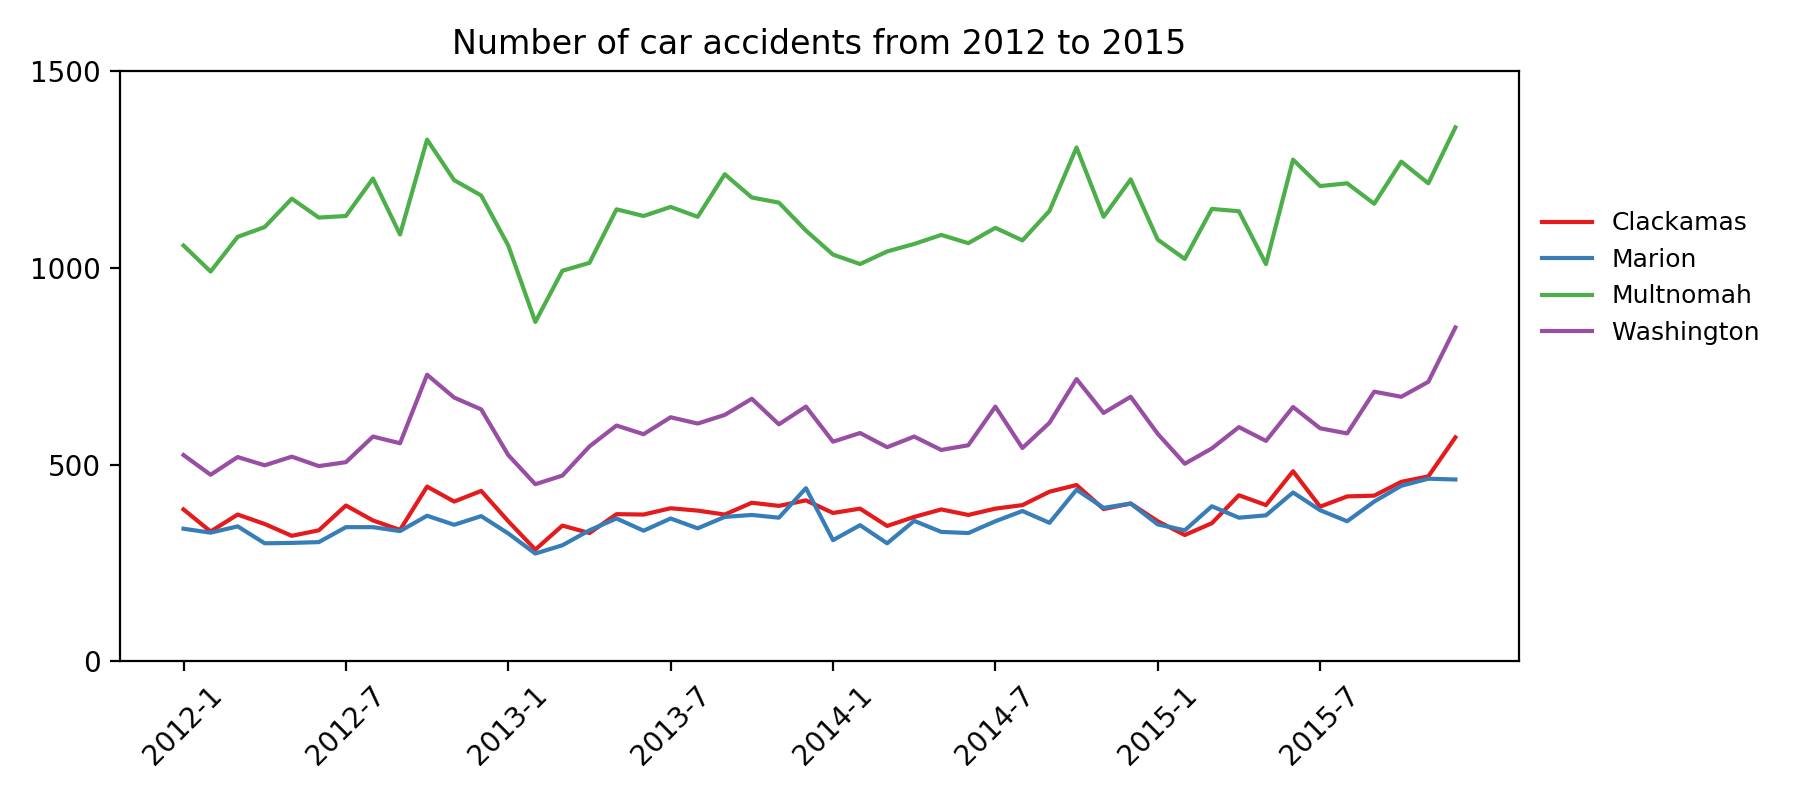

In [10]:
# Plot the trend out
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(Clackamas_yrmon.index, Clackamas_yrmon['Crash Number'], color=linecolors[0], label = 'Clackamas',zorder=0) 
ax.plot(Marion_yrmon.index, Marion_yrmon['Crash Number'], color=linecolors[1], label = 'Marion',zorder=0) 
ax.plot(Multnomah_yrmon.index, Multnomah_yrmon['Crash Number'], color=linecolors[2], label = 'Multnomah',zorder=0) 
ax.plot(Washington_yrmon.index, Washington_yrmon['Crash Number'], color=linecolors[3], label = 'Washington',zorder=0) 

ax.set_xticks(['201201', '201207', '201301', '201307', '201401', '201407', '201501', '201507'])
ax.set_xticklabels(['2012-1', '2012-7', '2013-1', '2013-7', '2014-1', '2014-7', '2015-1', '2015-7'])
for item in ax.xaxis.get_ticklabels():
    item.set_rotation(45) 
ax.set_yticks(np.arange(0, 1600, 500))
ax.set_title('Number of car accidents from 2012 to 2015')
ax.legend(bbox_to_anchor=(1, 0.8), loc=2, frameon=False, fontsize=9)
plt.tight_layout()

### Road category
Highway number 
Not sure if spatial data can be found, but check the data set first.

-  After checking, the highway number is not the actual official number of highway but just to order highway by names.
-  The highway numbers are string, so I think 001 and 1 should mean the same thing. NA values should be roads that are not highways.
-  More road information is found along with the shapefile (https://catalog.data.gov/dataset/tiger-line-shapefile-2013-state-oregon-primary-and-secondary-roads-state-based-shapefile).
-  According to the shapefile, highways are categorized into four types: I (Intersate), S (State), M (Municiple?), U (Urban).
-  We can categorize the NA road as Non-highway.
-  There is 'Route Type' and 'Route Number' in the data set as well.
-  There is 'Functional Class Code' in the data set, also showing road type.

In [11]:
# Use 'Functional Class Code' to record
class_code_dict = {1:'Rural Interstate', 2:'Other Rural Principle Arterial', 6:'Rural Minor Arterial',
                   7:'Rural Major Collector', 8:'Rural Minor Collector', 9:'Rural Local', 11:'Urban Interstate',
                   12:'Urban Other Freeways and Expressways', 14:'Urban Other Principle Arterial',
                   16:'Urban Minor Arterial', 17:'Urban Major Collector', 18:'Urban Minor Collector', 
                   19:'Urban Local'}
crashes['Functional Class Code'] = crashes['Functional Class Code'].replace(class_code_dict)
# print(crashes['Functional Class Code'].value_counts())

# Group road type
road_type_dict = {'Rural Interstate':'Interstate', 'Other Rural Principle Arterial':'Arterial', 
                  'Rural Minor Arterial':'Arterial', 'Rural Major Collector':'Collector', 
                  'Rural Minor Collector':'Collector', 'Rural Local':'Local', 'Urban Interstate':'Interstate',
                  'Urban Other Freeways and Expressways':'Freeway', 'Urban Other Principle Arterial':'Arterial',
                  'Urban Minor Arterial':'Arterial', 'Urban Major Collector':'Collector', 
                  'Urban Minor Collector':'Collector', 'Urban Local':'Local'}
crashes['Road Type'] = crashes['Functional Class Code'].map(lambda x: road_type_dict[x])
print(crashes['Road Type'].value_counts())

Arterial      72057
Collector     17693
Interstate    13725
Local         10059
Freeway        4803
Name: Road Type, dtype: int64


In [12]:
# Explore data road
crashes_road = crashes.groupby(['County', 'Crash Year', 'Road Type']).size().to_frame()
crashes_road.rename(index=str, columns={0: 'Crash Number'}, inplace=True)
crashes_road = crashes_road.reset_index(level=['County', 'Crash Year', 'Road Type'])
# crashes_road

county_road = dict()
yrs = ['2012', '2013', '2014', '2015']

for county in counties:
    county_road[county] = crashes_road[crashes_road['County']==county]
    county_road[county] = county_road[county].pivot(index='Road Type', columns='Crash Year', values='Crash Number')
    county_road[county] = county_road[county].rename_axis(None).rename_axis(None, axis=1)
    for yr in yrs:
        county_road[county][yr] = county_road[county][yr].div(county_road[county][yr].sum())

county_road['Marion']

,2012,2013,2014,2015
Arterial,0.713716,0.708423,0.715853,0.704077
Collector,0.099252,0.104392,0.095494,0.094157
Freeway,0.034165,0.031198,0.028485,0.033207
Interstate,0.071072,0.075354,0.089423,0.091845
Local,0.081796,0.080634,0.070745,0.076713


<IPython.core.display.Javascript object>


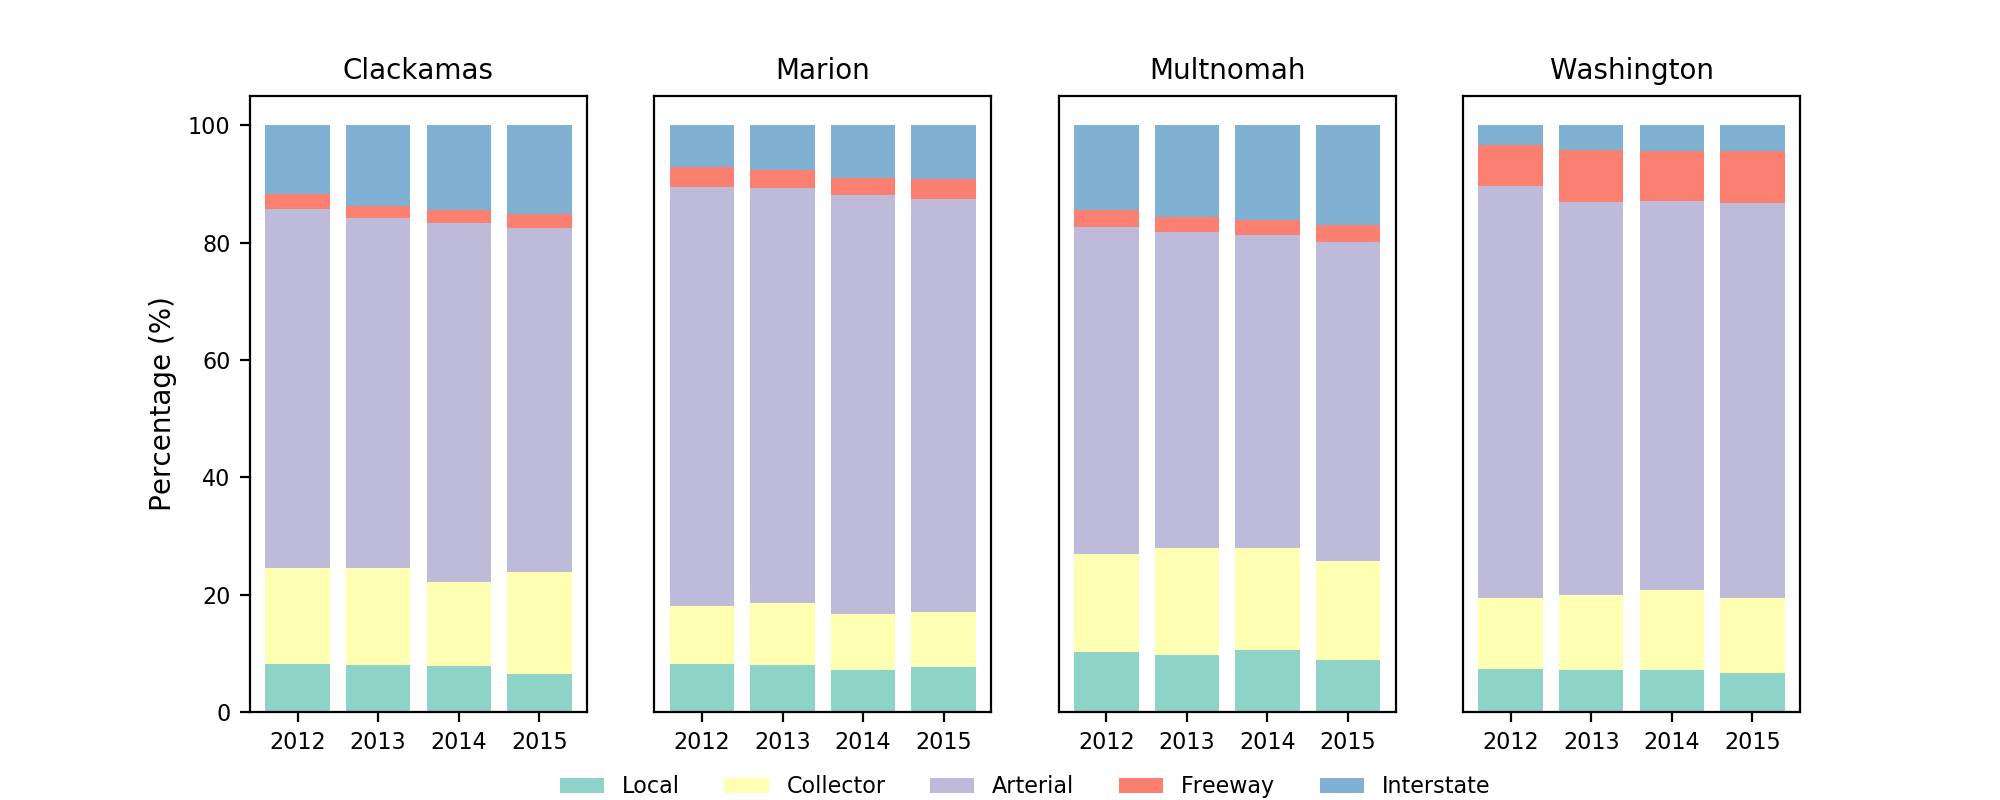

In [13]:
# plot all four counties
N=4
width = 0.8      
xticks = np.arange(N)
yticks = np.arange(0, 1.1, 0.2)
xticklabel = np.arange(2012, 2016, 1)
yticklabel = np.arange(0, 110, 20)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 4))
axes = [ax1, ax2, ax3, ax4]

for num in range(len(axes)):
    Local = county_road[counties[num]].loc['Local']
    Collector = county_road[counties[num]].loc['Collector']
    Arterial = county_road[counties[num]].loc['Arterial']
    Freeway = county_road[counties[num]].loc['Freeway']
    Interstate = county_road[counties[num]].loc['Interstate']
    
    axes[num].bar(xticks, Local, width, color='#8dd3c7', label='Local')
    axes[num].bar(xticks, Collector, width, color='#ffffb3', bottom=Local, label='Collector')
    axes[num].bar(xticks, Arterial, width, color='#bebada', bottom=Local+Collector, label='Arterial')
    axes[num].bar(xticks, Freeway, width, color='#fb8072', bottom=Local+Collector+Arterial, label='Freeway')
    axes[num].bar(xticks, Interstate, width, color='#80b1d3', bottom=Local+Collector+Arterial+Freeway, label='Interstate')
    
    axes[num].set_title(counties[num], fontsize=10)
    axes[num].set_xticks(xticks)
    axes[num].set_xticklabels(xticklabel, fontsize=8)
    
    if num==0:
        axes[num].set_ylabel('Percentage (%)')
        axes[num].set_yticks(yticks)
        axes[num].set_yticklabels(yticklabel, fontsize=8)
    else:
        axes[num].set_yticks([])
        if num==2:
            axes[num].legend(bbox_to_anchor=(-0.1, -0.07), loc=9, ncol=5, frameon=False, fontsize=8)



### Collision type
Explore proportions of accidents by different categories. Also examine by county and time.

<IPython.core.display.Javascript object>


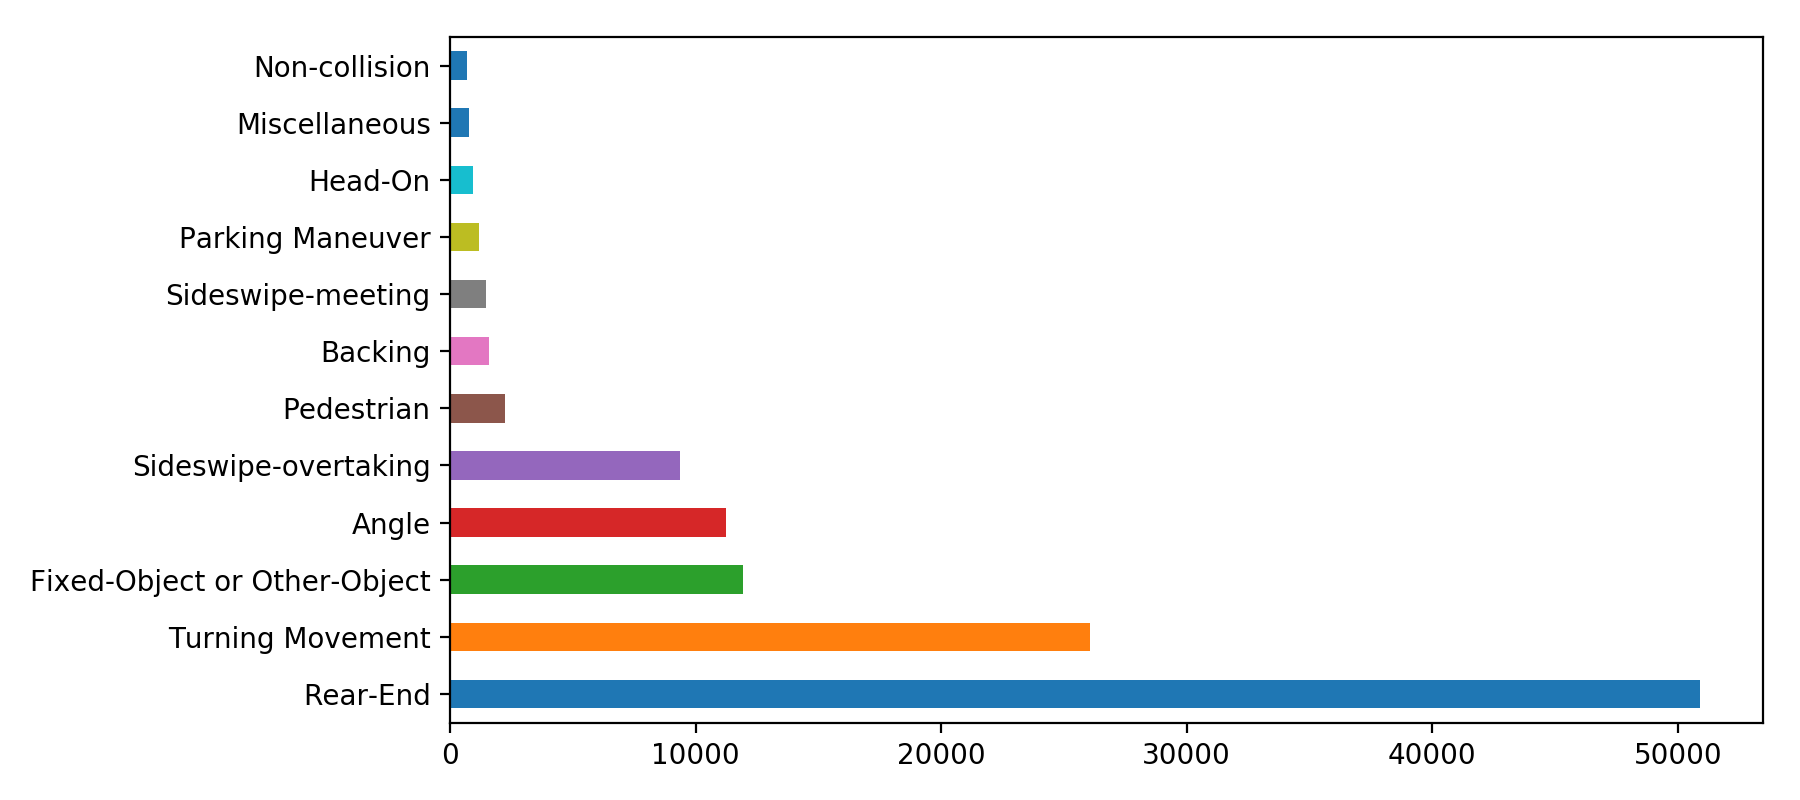

In [14]:
# summarize the collision type attribute with a chart
collision_dict = {'1':'Angle', '2': 'Head-On', '3':'Rear-End', '4':'Sideswipe-meeting', '5':'Sideswipe-overtaking', 
                  '6':'Turning Movement', '7':'Parking Maneuver', '8':'Non-collision', '9':'Fixed-Object or Other-Object', 
                  '0':'Pedestrian', '-':'Backing', '&':'Miscellaneous'}
                          
crashes['Collision Type'] = crashes['Collision Type'].replace(collision_dict)

collision_type_counts = crashes['Collision Type'].value_counts()
collision_type_counts.plot(kind='barh', figsize=(9, 4))
plt.tight_layout()

As there are way too many categories, it is more convenient to group a few categories and observe the more apprent trend first. I decide to use six groups (Rear-End, Turning Movement, Object, Angle, Sideswipe, Others) for now. 

<IPython.core.display.Javascript object>


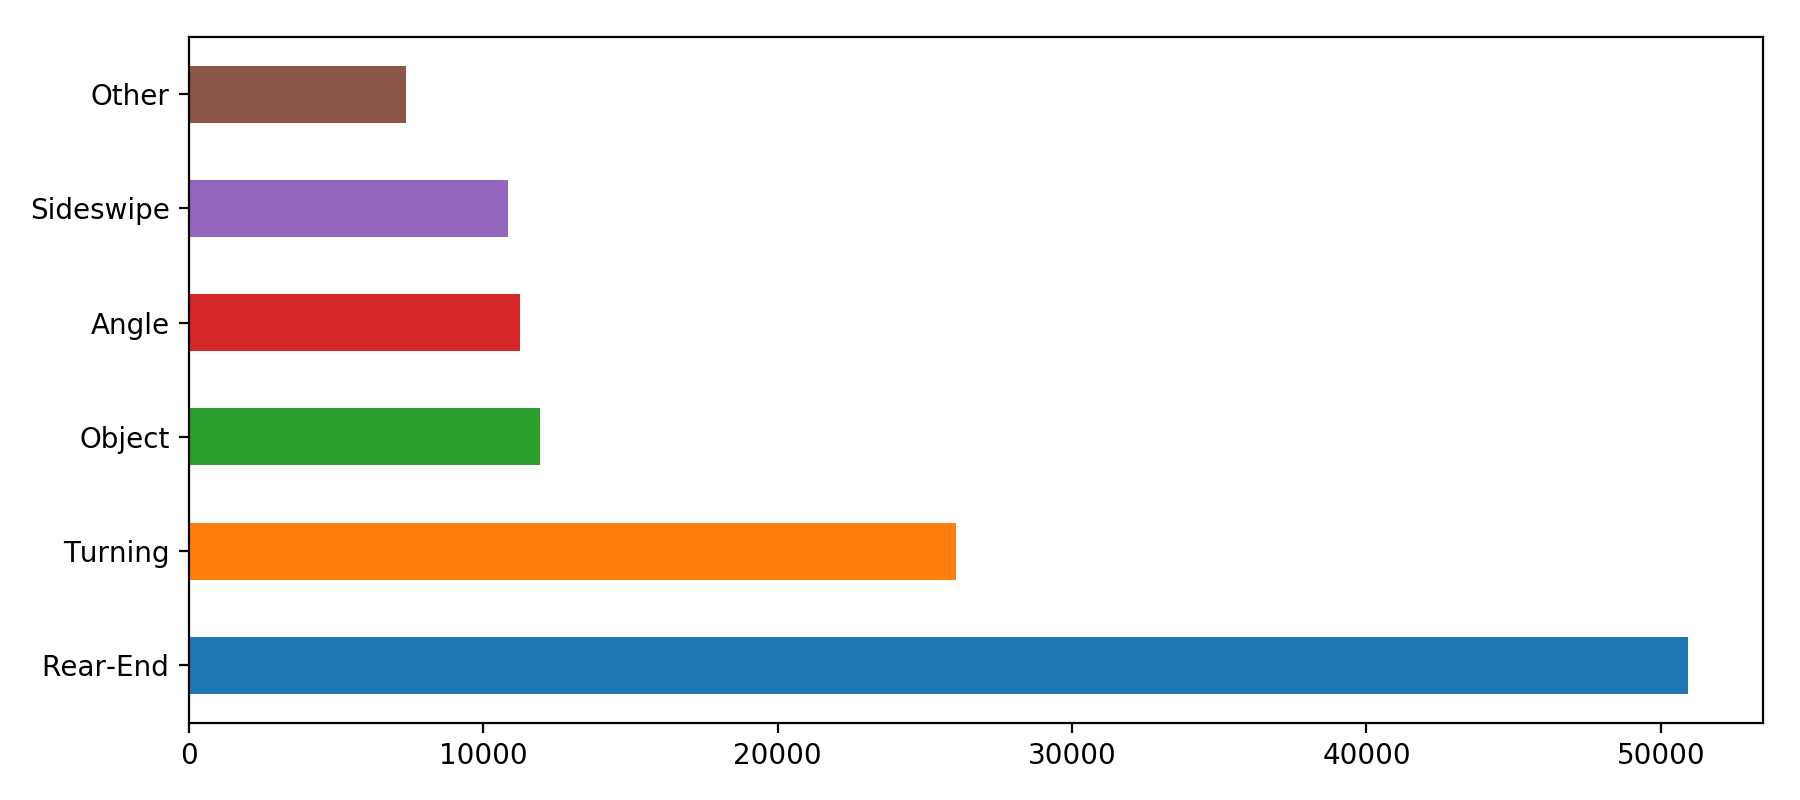

In [15]:
collision_group_dict = {'Angle':'Angle', 'Head-On':'Other', 'Rear-End':'Rear-End', 'Sideswipe-meeting':'Sideswipe', 
                        'Sideswipe-overtaking':'Sideswipe', 'Turning Movement':'Turning', 'Parking Maneuver':'Other', 
                        'Non-collision':'Other', 'Fixed-Object or Other-Object':'Object', 'Pedestrian':'Other', 
                        'Backing':'Other', 'Miscellaneous':'Other'}                    
crashes['Collision Type'] = crashes['Collision Type'].replace(collision_group_dict)
collision_group_counts = crashes['Collision Type'].value_counts()
collision_group_counts.plot(kind='barh', figsize=(9, 4))
plt.tight_layout()

In [16]:
# Explore data collision
crashes_collision = crashes.groupby(['County', 'Crash Year', 'Collision Type']).size().to_frame()
crashes_collision.rename(index=str, columns={0: 'Crash Number'}, inplace=True)
crashes_collision = crashes_collision.reset_index(level=['County', 'Crash Year', 'Collision Type'])
# crashes_collision

county_collision = dict()
yrs = ['2012', '2013', '2014', '2015']

for county in counties:
    county_collision[county] = crashes_collision[crashes_collision['County']==county]
    county_collision[county] = county_collision[county].pivot(index='Collision Type', columns='Crash Year', values='Crash Number')
    county_collision[county] = county_collision[county].rename_axis(None).rename_axis(None, axis=1)
    for yr in yrs:
        county_collision[county][yr] = county_collision[county][yr].div(county_collision[county][yr].sum())

<IPython.core.display.Javascript object>


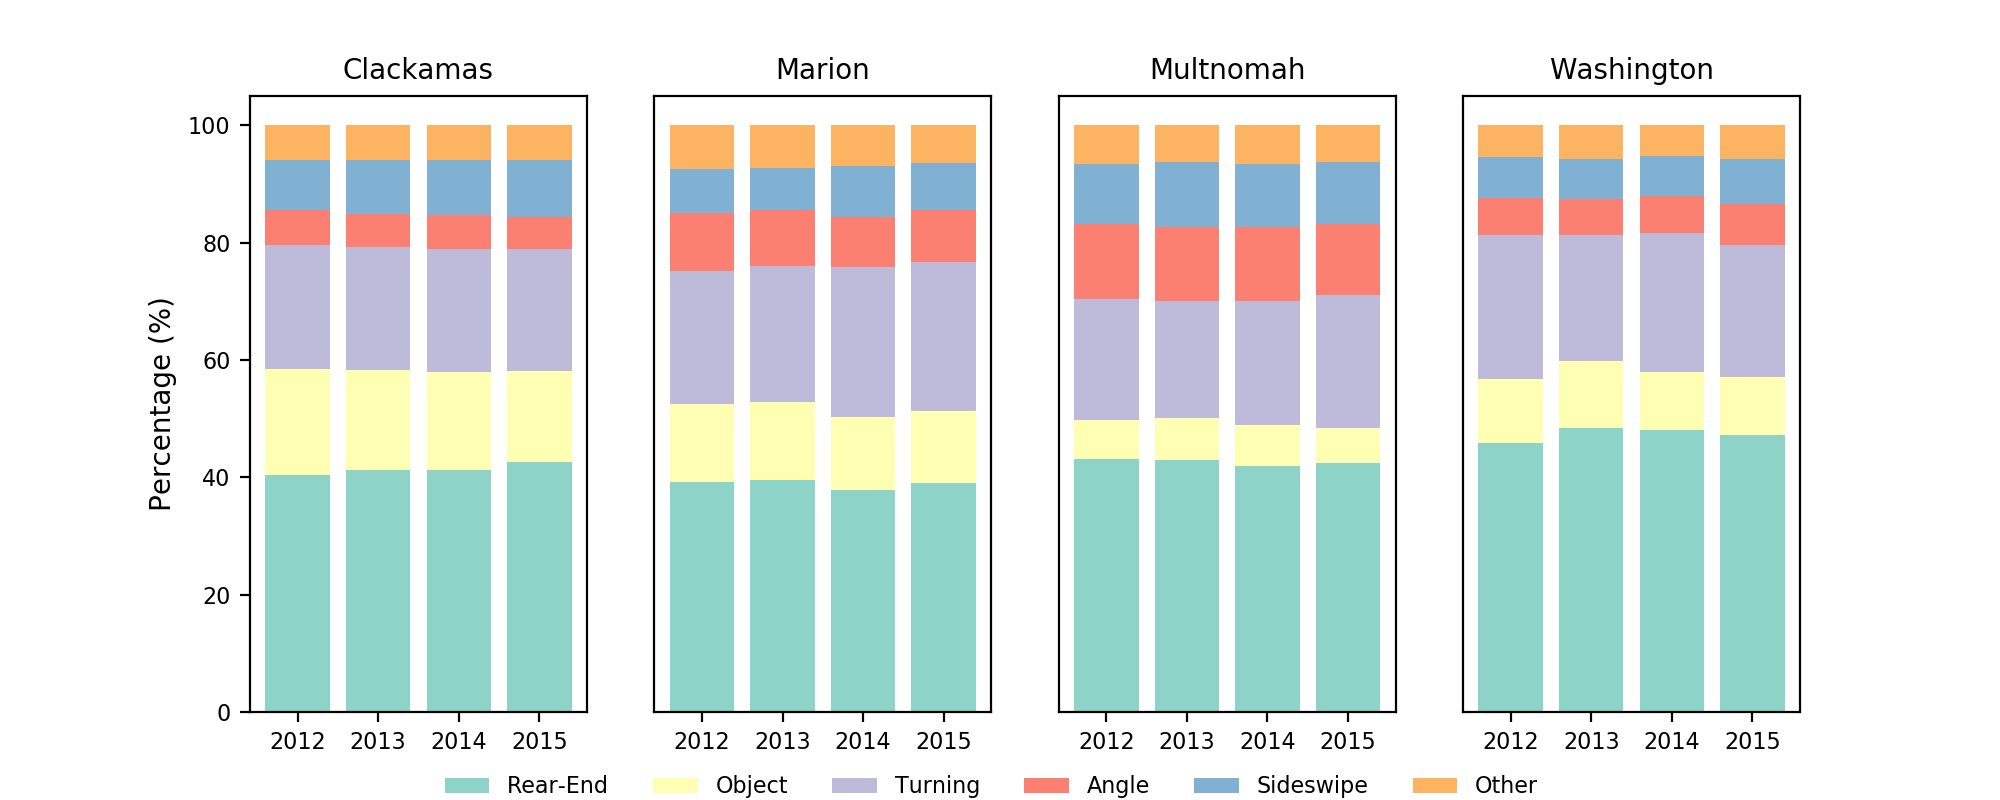

In [17]:
# plot all four counties
N=4
width = 0.8      
xticks = np.arange(N)
yticks = np.arange(0, 1.1, 0.2)
xticklabel = np.arange(2012, 2016, 1)
yticklabel = np.arange(0, 110, 20)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 4))
axes = [ax1, ax2, ax3, ax4]

for num in range(len(axes)):
    Rear = county_collision[counties[num]].loc['Rear-End']
    Object = county_collision[counties[num]].loc['Object']
    Turning = county_collision[counties[num]].loc['Turning']
    Angle = county_collision[counties[num]].loc['Angle']
    Sideswipe = county_collision[counties[num]].loc['Sideswipe']
    Other = county_collision[counties[num]].loc['Other']
    
    axes[num].bar(xticks, Rear, width, color='#8dd3c7', label='Rear-End')
    axes[num].bar(xticks, Object, width, color='#ffffb3', bottom=Rear, label='Object')
    axes[num].bar(xticks, Turning, width, color='#bebada', bottom=Rear+Object, label='Turning')
    axes[num].bar(xticks, Angle, width, color='#fb8072', bottom=Rear+Object+Turning, label='Angle')
    axes[num].bar(xticks, Sideswipe, width, color='#80b1d3', bottom=Rear+Object+Turning+Angle, label='Sideswipe')
    axes[num].bar(xticks, Other, width, color='#fdb462', bottom=Rear+Object+Turning+Angle+Sideswipe, label='Other')
    
    axes[num].set_title(counties[num], fontsize=10)
    axes[num].set_xticks(xticks)
    axes[num].set_xticklabels(xticklabel, fontsize=8)
    
    if num==0:
        axes[num].set_ylabel('Percentage (%)')
        axes[num].set_yticks(yticks)
        axes[num].set_yticklabels(yticklabel, fontsize=8)
    else:
        axes[num].set_yticks([])
        if num==2:
            axes[num].legend(bbox_to_anchor=(-0.2, -0.07), loc=9, ncol=6, frameon=False, fontsize=8)

## Prediction for 2016

### Number of crashes

In [18]:
# Use linear regression model from the sklearn module
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

- Option 1: build an individual linear regression model for each county

In [19]:
crashes_freq2 = crashes_freq.reset_index()
crashes_freq2

,Crash Year,County,Crash Number
0,2012,Clackamas,4461
1,2013,Clackamas,4410
2,2014,Clackamas,4686
3,2015,Clackamas,5058
4,2012,Marion,4010
5,2013,Marion,4167
6,2014,Marion,4283
7,2015,Marion,4758
8,2012,Multnomah,13700
9,2013,Multnomah,13158


In [20]:
# Build linear regression model by county
county_crash_freq = dict()
predict2016 = dict()
for county in counties:
    county_crash_freq[county] = crashes_freq2[crashes_freq2['County']==county].values[:,[0,2]].astype(int)
    X_train = county_crash_freq[county][:,0].reshape(-1,1)
    y_train = county_crash_freq[county][:,1].reshape(-1,1)
    X_test = np.asarray(2016)
    
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    # Append prediction
    predict2016[county] = y_pred[0][0]

predict2016

{'Clackamas': 5170.5,
 'Marion': 4894.5,
 'Multnomah': 13870.0,
 'Washington': 7735.0}

- Option 2: Use an overall model with indicator variables representing counties

In [21]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(crashes_freq2.values[:,1])
# print(integer_encoded)

In [22]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# print(onehot_encoded)

In [23]:
freq_X_train = np.concatenate((crashes_freq2.values[:,0].astype('int').reshape(-1,1), onehot_encoded), axis=1)
freq_y_train = crashes_freq2.values[:,-1].reshape(-1, 1)
freq_X_train

array([[2.012e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.013e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.014e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.015e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.012e+03, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
       [2.013e+03, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
       [2.014e+03, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
       [2.015e+03, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
       [2.012e+03, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00],
       [2.013e+03, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00],
       [2.014e+03, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00],
       [2.015e+03, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00],
       [2.012e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [2.013e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [2.014e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [2.015e+03, 0.000e+00, 0.000e+00,

In [24]:
yr_test = np.asarray([2016]*4).reshape(4,1)
freq_X_test = np.concatenate((yr_test, onehot_encoded[[0,4,8,12],:]), axis=1)
freq_X_test

array([[2.016e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.016e+03, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
       [2.016e+03, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00],
       [2.016e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]])

In [25]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(freq_X_train, freq_y_train)

# Make predictions using the testing set
freq_y_pred = regr.predict(freq_X_test)
freq_y_pred

array([[ 5175.1875],
       [ 4825.9375],
       [14073.4375],
       [ 7595.4375]])

### Crashes by month
At this moment, I do not know how to deal with time series data. So the predictinos made here are also merely drawn from linear regression models with 'Year' as a numerical varible and 'Month' as an indicator variable.

In [26]:
county_yrmon = {'Clackamas':Clackamas_yrmon, 'Marion':Marion_yrmon, 'Multnomah':Multnomah_yrmon, 
                'Washington':Washington_yrmon}
county_mon = dict()
county_mon_predict_2016 = []

for county in counties:
    county_mon[county] = county_yrmon[county].reset_index()
    county_mon[county]['Year'] = county_mon[county]['YearMonth'].apply(lambda x:int(x[:4]))
    county_mon[county]['Month'] = county_mon[county]['YearMonth'].apply(lambda x:x[4:])
    county_mon[county].drop(['YearMonth', 'County'], axis=1, inplace=True)
    # pandas get_dummies equivalent to onehot encoding
    county_mon[county] = pd.get_dummies(county_mon[county])

    mon_X_train = county_mon[county].values[:,1:]
    mon_y_train = county_mon[county].values[:,0]
    mon_X_test = np.hstack((np.asarray([2016]*12).reshape(-1,1), county_mon[county].values[:12, 2:]))

    regr = linear_model.LinearRegression()
    regr.fit(mon_X_train, mon_y_train)
    mon_y_pred = regr.predict(mon_X_test)
    county_mon_predict_2016.append(mon_y_pred)

county_mon_predict_2016 = np.asarray(county_mon_predict_2016)
print(county_mon_predict_2016)    # crashes by month and county
print(county_mon_predict_2016.sum(axis=1))    # crashes by county

[[ 411.8125      373.8125      396.3125      409.0625      412.0625
   433.3125      434.5625      432.3125      432.8125      480.8125
   457.5625      496.0625    ]
 [ 378.66666667  369.16666667  382.16666667  387.91666667  390.16666667
   396.66666667  410.16666667  403.41666667  413.16666667  455.16666667
   440.66666667  467.16666667]
 [1080.5         997.25       1091.5        1106.         1130.25
  1175.         1174.75       1186.         1183.25       1295.75
  1209.         1240.75      ]
 [ 601.08333333  556.58333333  574.08333333  607.58333333  609.08333333
   622.08333333  646.33333333  629.08333333  672.83333333  751.08333333
   708.33333333  756.83333333]]
[ 5170.5  4894.5 13870.   7735. ]


### Crashes by road category

In [27]:
county_road_predict_2016 = dict()

for county in counties:
    road = county_road[county].stack().reset_index()
    road['level_1'] = road['level_1'].astype('int')
    road = pd.get_dummies(road).values
    
    road_X_train = road[:,[0,2,3,4,5,6]]
    road_y_train = road[:,1]
    road_X_test = np.hstack((np.asarray([2016]*5).reshape(-1,1), road[[0,4,8,12,16], 2:]))

    regr = linear_model.LinearRegression()    
    regr.fit(road_X_train, road_y_train)
    road_y_pred = regr.predict(road_X_test)
#     county_road_predict_2016.append(road_y_pred)
    county_road_predict_2016[county] = road_y_pred

# county_road_predict_2016 = np.asarray(county_road_predict_2016)
county_road_predict_2016 = pd.DataFrame.from_dict(data=county_road_predict_2016, orient='index', 
                                                  columns=['Arterial', 'Collector', 'Freeway', 'Interstate', 'Local'])
county_road_predict_2016

,Arterial,Collector,Freeway,Interstate,Local
Clackamas,0.601987,0.161529,0.023114,0.137275,0.076095
Marion,0.710517,0.098324,0.031764,0.081924,0.077472
Multnomah,0.543577,0.172943,0.026956,0.158355,0.098169
Washington,0.677351,0.128007,0.083208,0.040601,0.070832


### Crashes by collision type

In [28]:
county_collision_predict_2016 = dict()

for county in counties:
    collision = county_collision[county].stack().reset_index()
    collision['level_1'] = collision['level_1'].astype('int')
    collision = pd.get_dummies(collision).values
    
    collision_X_train = collision[:,[0,2,3,4,5,6,7]]
    collision_y_train = collision[:,1]
    collision_X_test = np.hstack((np.asarray([2016]*6).reshape(-1,1), collision[[0,4,8,12,16,20], 2:]))

    regr = linear_model.LinearRegression()    
    regr.fit(collision_X_train, collision_y_train)
    collision_y_pred = regr.predict(collision_X_test)
    county_collision_predict_2016[county] = collision_y_pred

county_collision_predict_2016 = pd.DataFrame.from_dict(data=county_collision_predict_2016, orient='index', 
                                                       columns=['Angle', 'Object', 'Other', 'Rear-End', 
                                                                'Sideswipe', 'Turning'])
county_collision_predict_2016

,Angle,Object,Other,Rear-End,Sideswipe,Turning
Clackamas,0.057485,0.168658,0.059258,0.413860,0.091507,0.209232
Marion,0.091729,0.128641,0.070276,0.388689,0.078555,0.242109
Multnomah,0.125191,0.066382,0.064218,0.426427,0.106695,0.211087
Washington,0.064284,0.105467,0.055456,0.473611,0.070275,0.230908
